# __Lock in Amplifier Using EXPEYES__

### Importing the Libraries

In [1]:
import eyes17.eyes
import numpy as np
import math as m
import time
from scipy.fft import fft, ifft,fftfreq, fftshift
from tqdm import tqdm
import matplotlib.pyplot as plt

p=eyes17.eyes.open()

W###################-------------


### Defining the Frequencies and Amplitude of the Input Signal

In [34]:
# function generator settings
f = 1000 #Hz
amp = 2 #V

# expeyes17 settings
N_sample = 8192
N_div=64
t_gap = (1/(f*N_div))*10**6 #us

# experimental settings
warmup = True
triggering = False
right_clip = False

In [35]:
print(f"f = {f} Hz")
print(f"amp = {amp} V")
print(f"N_sample = {N_sample}")
print(f"N_div = {N_div}")
print(f"t_gap = {t_gap} us")


f = 1000 Hz
amp = 2 V
N_sample = 8192
N_div = 64
t_gap = 15.625 us


### Setting the Input Signal as a sine wave of frequency 1000Hz

In [36]:
warmup_values = [100,500,1000,2000,4000]
for val in range(4500,8001,500):
    warmup_values.append(val)
for val in [8100,8190,8192]:
    warmup_values.append(val)

def warmup_expeyes(t_gap,warmup_values):
    for val in tqdm(warmup_values):
        t,v, tt,vv = p.capture2(val, t_gap)

In [37]:
if warmup: warmup_expeyes(t_gap,warmup_values)

100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


In [38]:
t,v, tt,vv = p.capture2(N_sample, t_gap)

In [39]:
print(f"t_gap = {t_gap} us")
print(f"N_sample = {N_sample}")

print(f"len(t) = {len(t)}")

t_gap = 15.625 us
N_sample = 8192
len(t) = 5000


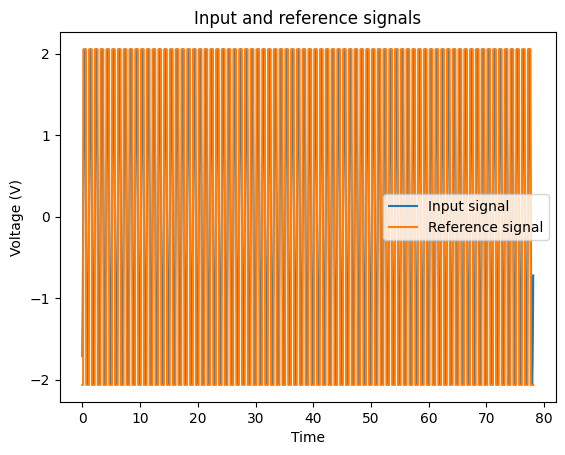

length of input signal = 5000


In [40]:
plt.plot(t,v, label='Input signal')
plt.plot(tt,vv, label='Reference signal')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Input and reference signals')
plt.legend()
plt.show()
print(f"length of input signal = {len(v)}")

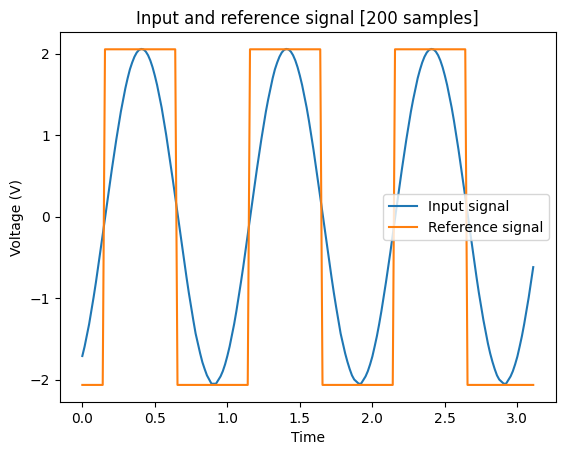

In [41]:
plt.plot(t[:200],v[:200], label='Input signal')
plt.plot(tt[:200],vv[:200], label='Reference signal')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Input and reference signal [200 samples]')
plt.legend()
plt.show()

### Generating the Reference Signals (Sine and Cosine)

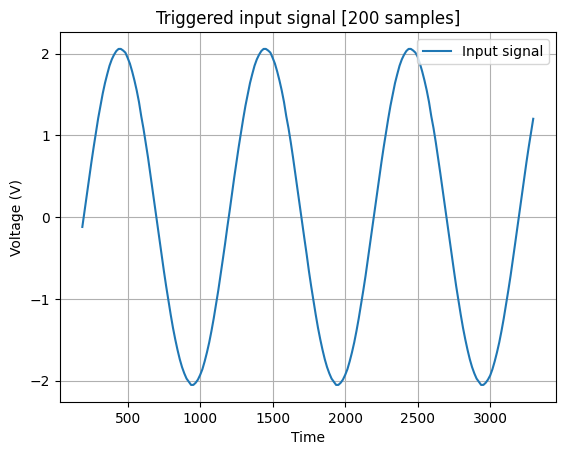

In [42]:
# trigger the reference signal vv by rising edge
def trigger(vv):
    for i in range(len(vv)-1):
        if vv[i] < 0 and vv[i+1] > 0:
            return i + 1
    return i

if triggering:
    trigger_index = trigger(vv)
    print(f"Trigger index = {trigger_index}")

    triggered_t = t[trigger_index:]
    triggered_v = v[trigger_index:]
    triggered_vv = vv[trigger_index:]

def right_clip_trigger(triggered_vv):

    right_clip_index = len(triggered_vv) - 1
    for i in range(right_clip_index, 0, -1):
        if triggered_vv[i] > 0 and triggered_vv[i-1] < 0:
            return i - 1
    return i

if right_clip:
    right_clip_index = right_clip_trigger(triggered_vv)
    print(f"Right clip index = {right_clip_index}")

    triggered_t = triggered_t[:right_clip_index]
    triggered_v = triggered_v[:right_clip_index]
    triggered_vv = triggered_vv[:right_clip_index]

# plotting the triggered input signal
cutoff = 200
plt.plot(triggered_t[:cutoff]*1000,triggered_v[:cutoff], label='Input signal')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title(f'Triggered input signal [{cutoff} samples]')
plt.grid()
plt.legend()
plt.show()

In [43]:
V_sin_ref=[]
V_cos_ref=[]
t_ref = []

curr_N_sample = len(triggered_v)
for i in range(curr_N_sample):
    V_sin_ref.append(amp*m.sin(2*m.pi*f*i*t_gap*10**-6))
    V_cos_ref.append(amp*m.cos(2*m.pi*f*i*t_gap*10**-6))
    t_ref.append(i*t_gap)

print(len(V_sin_ref))    


4928


### Plotting the Reference and the input signals

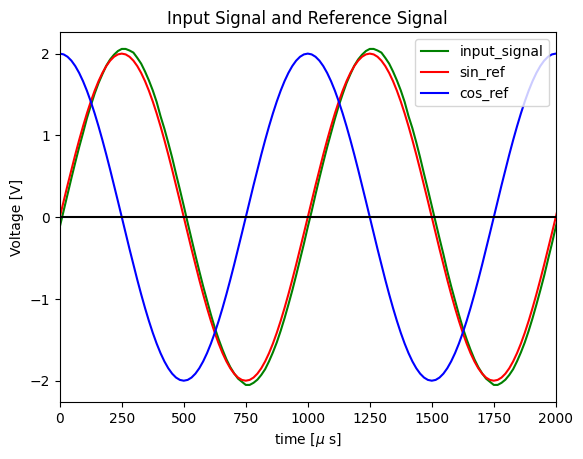

In [44]:
import matplotlib.pyplot as plt
plt.plot(t_ref,triggered_v,color='green',label='input_signal')
plt.plot(t_ref,V_sin_ref,color='red',label='sin_ref')
plt.plot(t_ref,V_cos_ref,color='blue',label='cos_ref')
plt.xlabel(r'time [$\mu $ s]')
plt.ylabel('Voltage [V]')
plt.xlim(0,2000)
plt.legend()
plt.title('Input Signal and Reference Signal')
plt.axhline(y=0, c="black")
plt.show()

### Phase matching (Multipling the input with sin)

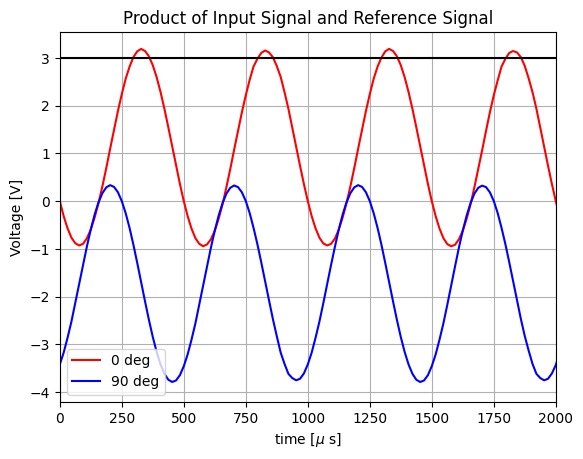

In [45]:
v_pm_sin = []
v_pm_cos = []
for i in range(curr_N_sample):
    v_pm_sin.append(v[i]*V_sin_ref[i])
    v_pm_cos.append(v[i]*V_cos_ref[i])

import matplotlib.pyplot as plt_pm
plt_pm.plot(t_ref,v_pm_sin,color='red',label='0 deg')
plt_pm.plot(t_ref,v_pm_cos,color='blue',label='90 deg')
plt_pm.xlabel(r'time [$\mu $ s]')
plt_pm.title('Product of Input Signal and Reference Signal')
plt_pm.ylabel('Voltage [V]')
plt_pm.xlim(0,2000)
plt_pm.legend()
plt_pm.axhline(y=3, c="black")
plt.grid()
plt_pm.show()


### Taking FFT for Low Pass Filter

In [46]:
freq=fftfreq(curr_N_sample,(t[1]-t[0])*0.001)
sine_fft=fft(v_pm_sin)
cos_fft=fft(v_pm_cos)

### Plotting the Sine wave in the frequency domain

c:\Users\Dell\Desktop\adhil-anagha_expeyes\Lockin_expeyes\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Dell\Desktop\adhil-anagha_expeyes\Lockin_expeyes\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


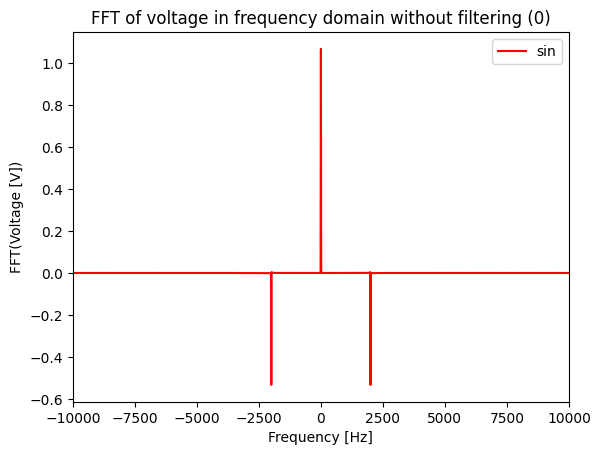

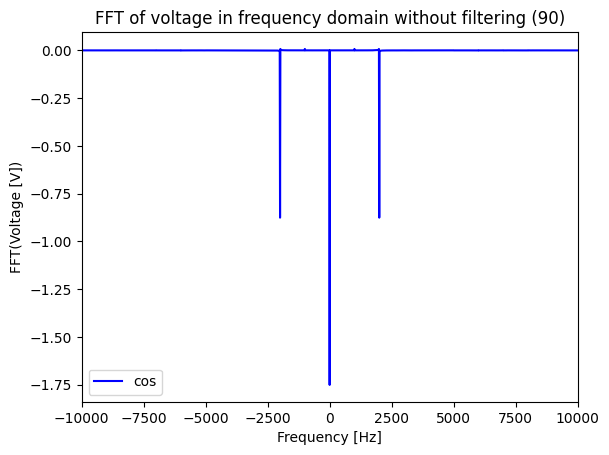

In [47]:
xf = fftshift(freq)
yplot = (1/curr_N_sample) * fftshift(sine_fft)


import matplotlib.pyplot as plt_fft
plt_fft.plot(xf,(yplot),color='red',label='sin')
plt_fft.xlabel(r'Frequency [Hz]')
plt_fft.ylabel('FFT(Voltage [V])')
plt_fft.title('FFT of voltage in frequency domain without filtering (0)')
plt_fft.xlim(-10000,10000)
plt_fft.legend()
plt_fft.show()

yplot = (1/curr_N_sample) * fftshift(cos_fft)

import matplotlib.pyplot as plt_fft
plt_fft.plot(xf,(yplot),color='blue',label='cos')
plt_fft.xlabel(r'Frequency [Hz]')
plt_fft.ylabel('FFT(Voltage [V])')
plt_fft.title('FFT of voltage in frequency domain without filtering (90)')
plt_fft.xlim(-10000,10000)
plt_fft.legend()
plt_fft.show()


### Calculating the Voltages

In [48]:
print("X component of the output Voltage",sine_fft[0].real/len(sine_fft))
print("Y component of the Output Voltage",cos_fft[0].real/len(cos_fft))
print("Voltage is",np.sqrt((sine_fft[0].real/len(sine_fft))**2+(cos_fft[0].real/len(cos_fft))**2),"V")

print("Phase of the output Voltage",m.atan((cos_fft[0].real/len(cos_fft))/(sine_fft[0].real/len(sine_fft)))*180/m.pi,"deg")

X component of the output Voltage 1.0681816636680852
Y component of the Output Voltage -1.7510220021109533
Voltage is 2.0511192355573504 V
Phase of the output Voltage -58.61542002131368 deg


# Single run

In [4]:
# import libraries

import eyes17.eyes
import numpy as np
import math as m
import time
from scipy.fft import fft, ifft,fftfreq, fftshift
import matplotlib.pyplot as plt

p=eyes17.eyes.open()

# required functions

def warmup_expeyes(t_gap):
    warmup_values = []
    # warmup_values = [100,500,1000,2000,4000]
    for val in range(4500,8001,500):
        warmup_values.append(val)
    for val in [8100,8190,8192]:
        warmup_values.append(val)
    for val in warmup_values:
        t,v, tt,vv = p.capture2(val, t_gap)


# function generator settings

# function generator settings
f = 500 #Hz
amp = 2 #V

# expeyes17 settings
N_sample = 10000
N_div=64
t_gap = (1/(f*N_div))*10**6 #us
voltage_range_A1 = 0.25
voltage_range_A2 = 1.5
p.select_range('A1',voltage_range_A1)
p.select_range('A2',voltage_range_A2)

# experimental settings
warmup = True # if True, the warmup is done ince at beginning
warmup_repititive = False #if True, the warmup is done for multiple values of N_sample
triggering = False
right_clip = False

auto_freq = False #if True, the frequency is automatically calculated and t_gap adjusted
freq_method = 'fft' # 'fft' or 'zero_crossing'
sq_wave_quadrature_method = 'phase_lag' # 'sin_cos' or 'phase_lag'


# internal settings dont touch!
warmup_flag = 0

print("settings ready!")

W###################-------------
settings ready!


In [5]:
def Lockin_detector_single_run(warmup_flag, f, t_gap):
    if warmup and warmup_flag == 0: 
        if warmup_repititive: print("Performing repititive warmup...")
        else: print("Performing a warmup run.. coz the Expeyes misbehaving otherwise!")
            
        warmup_expeyes(t_gap)
        warmup_flag = 1
    elif not warmup:
        print("NO WARMuP.. POSSIBLE FAILURE OF CAPTURE2...")
    t,v, tt,vv = p.capture2(N_sample, t_gap)

    v= np.array(v)
    vv = np.array(vv)

    # trigger the reference signal vv by rising edge
    def trigger(vv):
        for i in range(len(vv)-1):
            if vv[i] < 0 and vv[i+1] > 0:
                return i + 1
        return i

    def right_clip_trigger(triggered_vv):

        right_clip_index = len(triggered_vv) - 1
        for i in range(right_clip_index, 0, -1):
            if triggered_vv[i] > 0 and triggered_vv[i-1] < 0:
                return i - 1
        return i


    if triggering:
        trigger_index = trigger(vv)
        # print(f"Trigger index = {trigger_index}")

        triggered_t = t[trigger_index:]
        triggered_v = v[trigger_index:]
        triggered_vv = vv[trigger_index:]
    else:
        triggered_t = t
        triggered_v = v
        triggered_vv = vv

    if auto_freq:
        if freq_method == 'fft':
            freq=fftfreq(len(vv),(t[1]-t[0])*0.001)
            sine_fft=fft(vv)
            xf = fftshift(freq)
            yplot = (1/len(v)) * fftshift(sine_fft)

            # only positive frequencies
            xf2 = xf[xf>0]
            yplot2 = np.abs(yplot[xf>0])

            # plt.plot(xf2,(yplot2),color='red',label='sin')
            # plt.xlabel(r'Frequency [Hz]')
            # plt.ylabel('FFT(Voltage [V])')
            # plt.title('FFT of reference voltage in frequency domain')
            # # plt.xlim(0,10000)
            # plt.legend()
            # plt.show()

            # finding the max peak value
            peak_value = np.max(yplot2)

            # finding the first peak that is greater than 0.5 times the peak value

            peak_index = np.where(yplot2 > 0.8*peak_value)[0][0]

            freq = xf2[peak_index]

            
        elif freq_method == 'zero_crossing':
            zero_crossings = np.where(np.diff(np.sign(vv)))[0]
            freq = 1/(2*(t[zero_crossings[1]]-t[zero_crossings[0]]))
        
        print(f"Auto detected frequency = {freq} Hz")
    else:
        freq = f

    V_sin_ref=[]
    V_cos_ref=[]
    t_ref = []

    curr_N_sample = len(triggered_v)
    for i in range(curr_N_sample):
        V_sin_ref.append(amp*m.sin(2*m.pi*freq*i*t_gap*10**-6))
        V_cos_ref.append(amp*m.cos(2*m.pi*freq*i*t_gap*10**-6))
        t_ref.append(i*t_gap)

    if sq_wave_quadrature_method == 'sin_cos':
        v_sq_inphase = np.sign(V_sin_ref)
        v_sq_quadrature = np.sign(V_cos_ref)
    elif sq_wave_quadrature_method == 'phase_lag':
        triggered_vv = np.sign(triggered_vv)

        v_sq_inphase = triggered_vv
        
        # finding the next zero crossing of the reference signal

        zero_crossings = np.where(np.diff(np.sign(vv)))[0]
        index_difference = (zero_crossings[1]-zero_crossings[0]) // 2

        v_sq_quadrature = np.sign(triggered_vv[index_difference:])

        # making the length of all signals equal
        v_sq_inphase = v_sq_inphase[:len(v_sq_quadrature)]
        triggered_t = triggered_t[:len(v_sq_quadrature)]
        triggered_v = triggered_v[:len(v_sq_quadrature)]
        triggered_vv = triggered_vv[:len(v_sq_quadrature)]
        t_ref = t_ref[:len(v_sq_quadrature)]
        V_sin_ref = V_sin_ref[:len(v_sq_quadrature)]
        V_cos_ref = V_cos_ref[:len(v_sq_quadrature)]


    if right_clip:
        right_clip_index = right_clip_trigger(triggered_vv)
        # print(f"Right clip index = {right_clip_index}")

        triggered_t = triggered_t[:right_clip_index]
        triggered_v = triggered_v[:right_clip_index]
        triggered_vv = triggered_vv[:right_clip_index]
        v_sq_inphase = v_sq_inphase[:right_clip_index]
        v_sq_quadrature = v_sq_quadrature[:right_clip_index]
        V_sin_ref = V_sin_ref[:right_clip_index]
        V_cos_ref = V_cos_ref[:right_clip_index]
        t_ref = t_ref[:right_clip_index]

    curr_N_sample = len(triggered_v)

    # # plotting the triggered input signal
    # cutoff = 200
    # plt.plot(triggered_t[:cutoff]*1000,triggered_v[:cutoff], label='Input signal')
    # plt.xlabel('Time')
    # plt.ylabel('Voltage (V)')
    # plt.title(f'Triggered input signal [{cutoff} samples]')
    # plt.grid()
    # plt.legend()
    # plt.show()


    # plt.plot(t_ref,triggered_v,color='green',label='input_signal')
    # plt.plot(t_ref,triggered_vv,color='black',label='reference_signal')
    # # # plt.plot(t_ref,V_sin_ref,color='red',label='sin_ref')
    # # # plt.plot(t_ref,V_cos_ref,color='blue',label='cos_ref')
    # plt.xlabel(r'time [$\mu $ s]')
    # plt.ylabel('Voltage [V]')
    # # plt.xlim(0,20000)
    # plt.legend()
    # plt.title('Input Signal and Reference Signal')
    # plt.legend()
    # plt.grid()
    # plt.show()

    y_inphase = triggered_v * v_sq_inphase
    y_quadrature = triggered_v * v_sq_quadrature

    # performing the operations
    sum_y_inphase = np.sum(y_inphase) / len(y_inphase)
    sum_y_quadrature = np.sum(y_quadrature) / len(y_quadrature)

    N_per_cycle = N_div // 4

    # Observed amplitude and phase
    A = np.sqrt(sum_y_inphase ** 2 + sum_y_quadrature ** 2) *( np.pi / 2)

    phase = np.arctan2(sum_y_quadrature, sum_y_inphase) + (np.pi / (4 * N_per_cycle))

    print('Observed Amplitude:', A)
    print(f'Observed Phase: {np.rad2deg(phase)} deg')

    return A, np.rad2deg(phase), warmup_flag

In [ ]:
Lockin_detector_single_run(warmup_flag, f, t_gap)

### Mutual inductance experiment


In [58]:
frequencies = [] # Hz 
Vin_allfreq = [] # Vp (V)

# Vout observed through Lockin detector (V)
Vout_obs_allfreq = []

# Phase observed through Lockin detector (degrees)
Phase_obs_allfreq = []

trial_name = 'trial3_manualfreq'

Running for f = 1500 Hz
t_gap = 10.416666666666666 us
Performing a warmup run.. coz the Expeyes misbehaving otherwise!


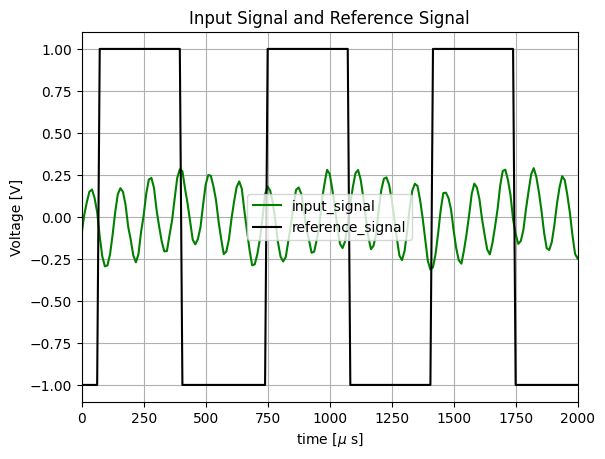

Observed Amplitude: 0.06460450886387024
Observed Phase: -102.86341227074261 deg


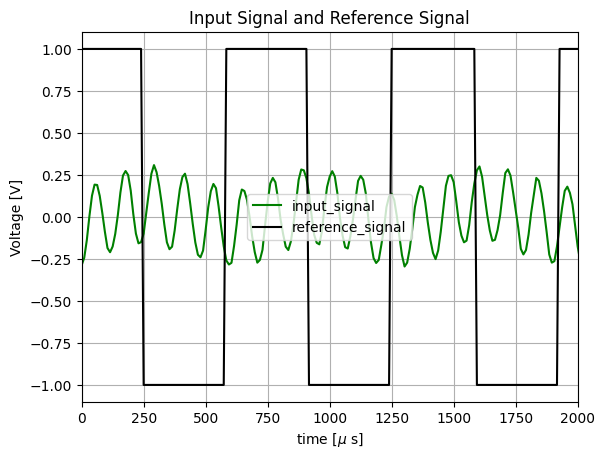

Observed Amplitude: 0.06455474737959903
Observed Phase: -102.87835488069649 deg


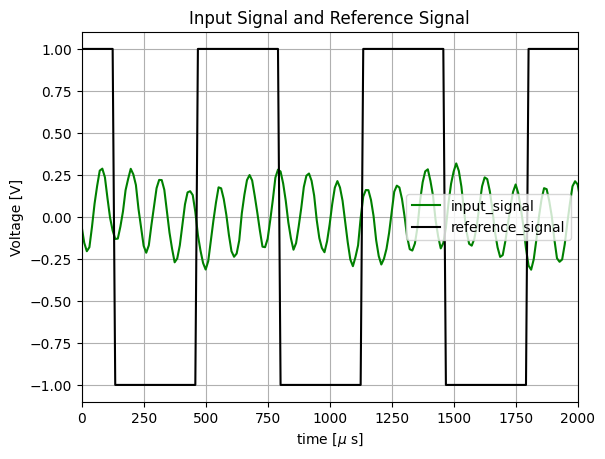

Observed Amplitude: 0.06485896632269095
Observed Phase: -103.07379646940473 deg


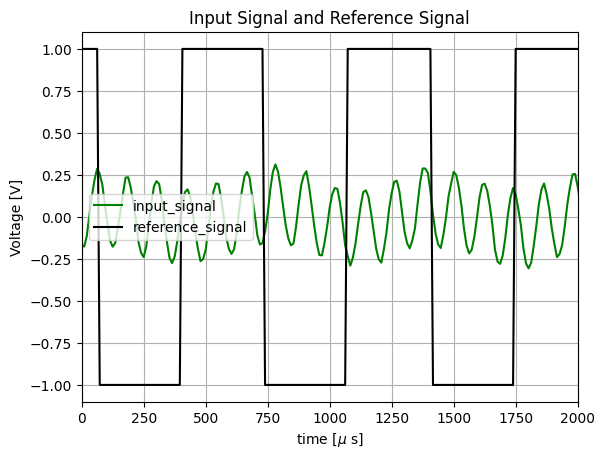

Observed Amplitude: 0.06469184065891039
Observed Phase: -103.02402632591615 deg


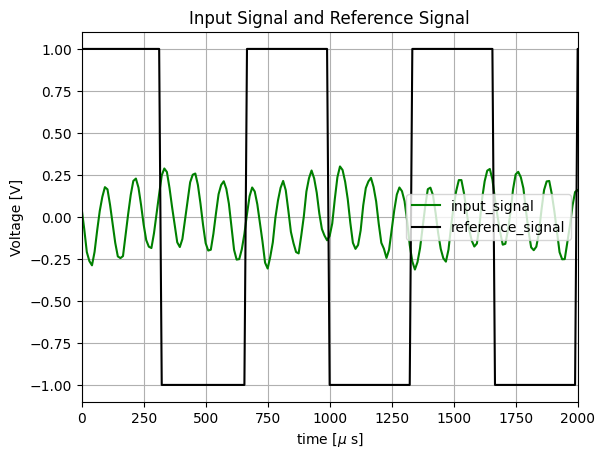

Observed Amplitude: 0.06509124702606223
Observed Phase: -103.89686891923651 deg


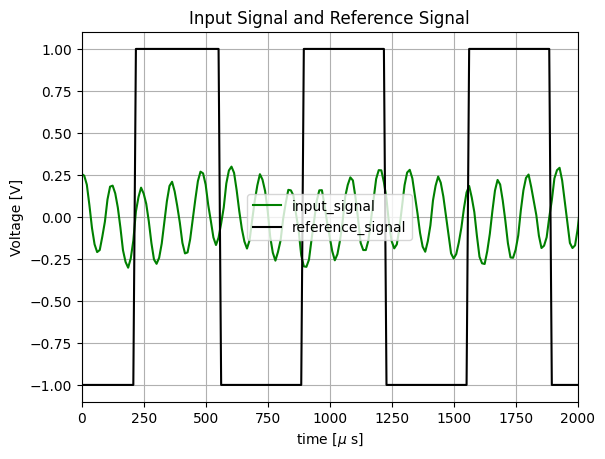

Observed Amplitude: 0.06389805411894098
Observed Phase: -102.07690133220397 deg


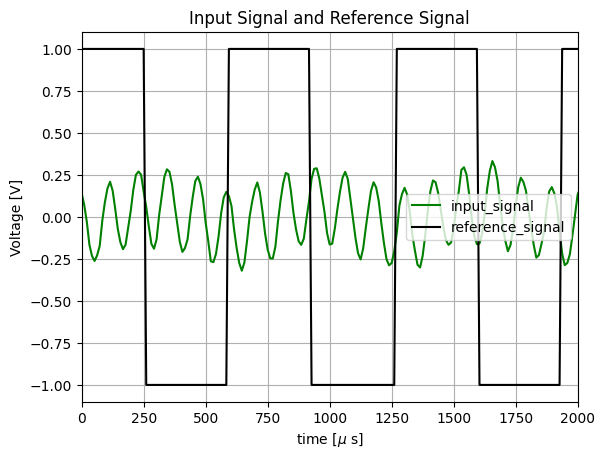

Observed Amplitude: 0.06485533363978571
Observed Phase: -103.61980997258135 deg


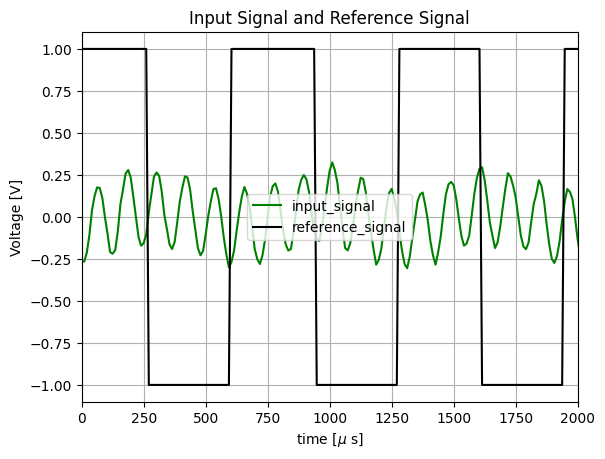

Observed Amplitude: 0.06387580786908598
Observed Phase: -103.3698798189241 deg


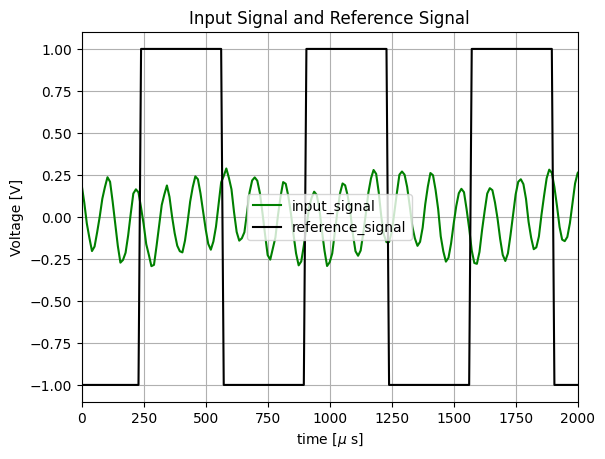

Observed Amplitude: 0.0641742440443736
Observed Phase: -103.4117348846801 deg


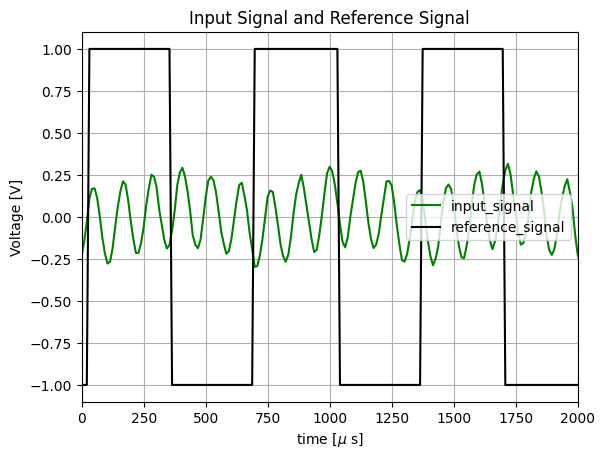

Observed Amplitude: 0.06426761138646217
Observed Phase: -103.17128745469005 deg


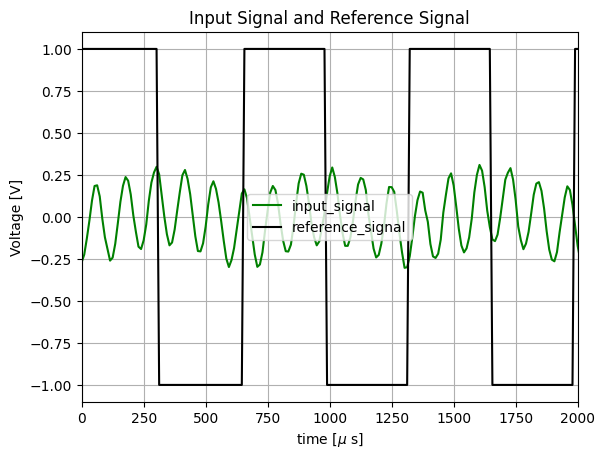

Observed Amplitude: 0.065323283762474
Observed Phase: -102.17710288630367 deg


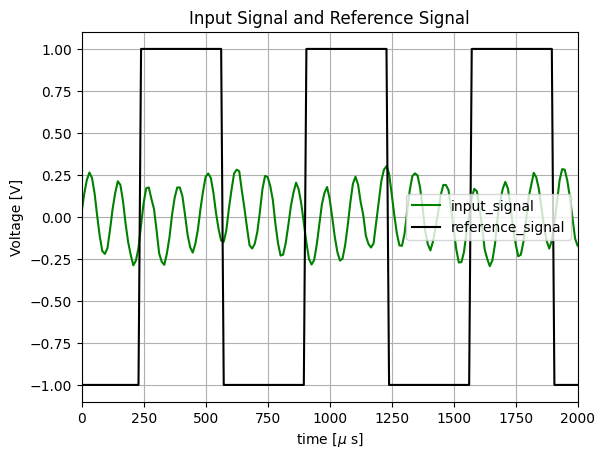

Observed Amplitude: 0.06485236180507066
Observed Phase: -102.53679124558164 deg


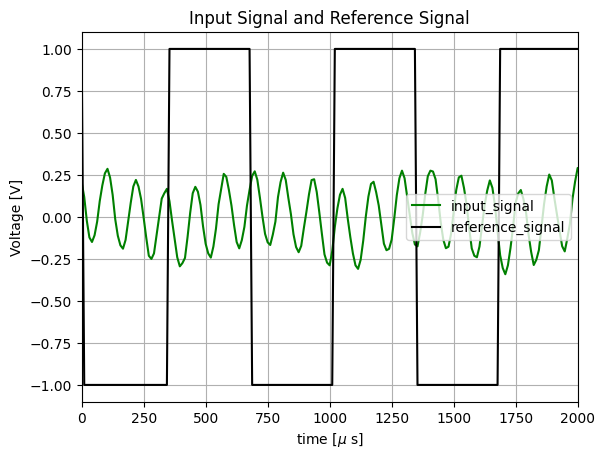

Observed Amplitude: 0.06336216142618073
Observed Phase: -101.77021269361437 deg


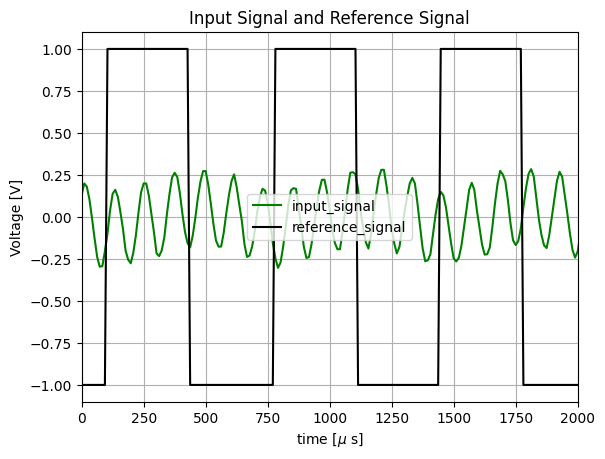

Observed Amplitude: 0.06429026911429755
Observed Phase: -103.02568881197148 deg


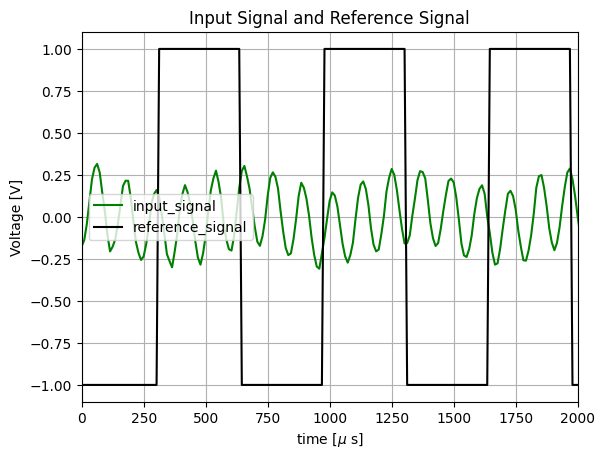

Observed Amplitude: 0.0647472298131188
Observed Phase: -102.98625314732604 deg


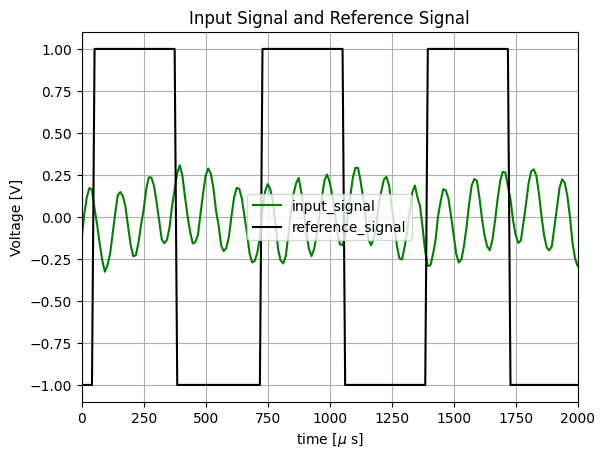

Observed Amplitude: 0.06527855927342552
Observed Phase: -103.20076190586873 deg


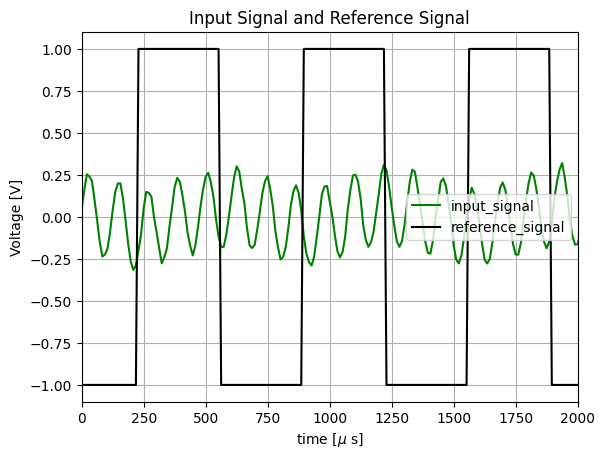

Observed Amplitude: 0.06458791334040304
Observed Phase: -102.87456768578768 deg


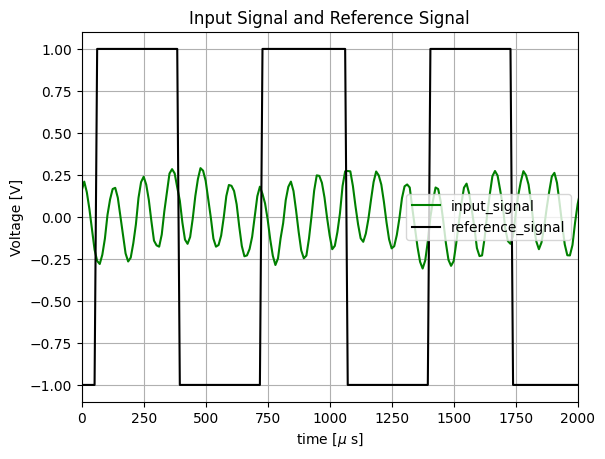

Observed Amplitude: 0.06440644012402297
Observed Phase: -103.01802403754937 deg


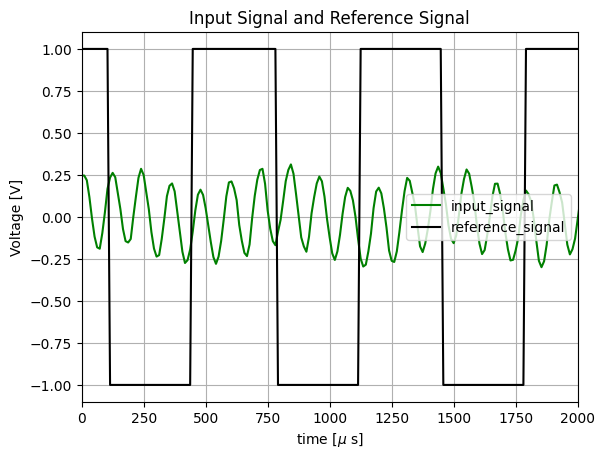

Observed Amplitude: 0.06512872618599176
Observed Phase: -102.37604906004667 deg


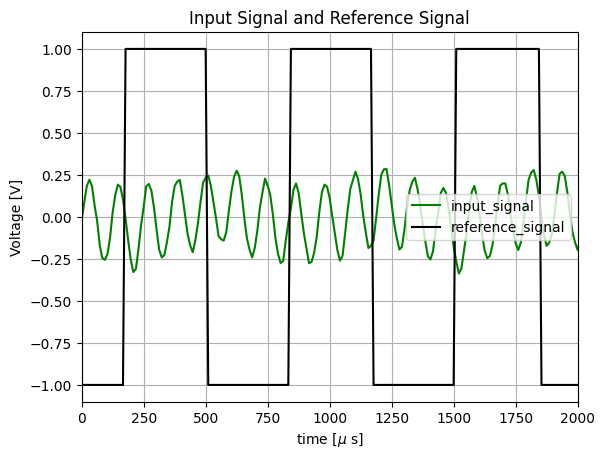

Observed Amplitude: 0.06549800964201262
Observed Phase: -102.79588342280023 deg


In [59]:
curr_freq = 1500

if len(frequencies) == 0 or frequencies[-1] != curr_freq:
    frequencies.append(curr_freq)

    Vin = [] # Vpp (V)

    # Vout observed through Lockin detector (V)
    Vout_obs = []

    # Phase observed through Lockin detector (degrees)
    Phase_obs = []

    f = curr_freq

    t_gap = (1/(f*N_div))*10**6 #us
    warmup_flag = 0
    print(f"Running for f = {f} Hz")
    print(f"t_gap = {t_gap} us")

Curr_Vin = 4

Vin.append(Curr_Vin)
for i in range(20):
    A , phase, warmup_flag = Lockin_detector_single_run(warmup_flag, f, t_gap)
    
    if i == 0:
        Vout_obs.append([A])
        Phase_obs.append([phase])
    else:
        Vout_obs[-1].append(A)
        Phase_obs[-1].append(phase)

if Curr_Vin == 4:
    Vin = np.array(Vin)
    Vout_obs = np.array(Vout_obs)
    Phase_obs = np.array(Phase_obs)

    Vin_allfreq.append(Vin)
    Vout_obs_allfreq.append(Vout_obs)
    Phase_obs_allfreq.append(Phase_obs)

In [46]:
np.save(f'Vin_allfreq{trial_name}.npy',Vin_allfreq)
np.save(f'Vout_obs_allfreq{trial_name}.npy',Vout_obs_allfreq)
np.save(f'Phase_obs_allfreq{trial_name}.npy',Phase_obs_allfreq)
np.save(f'frequencies{trial_name}.npy',frequencies)

In [1]:
# load data and process
import numpy as np
import matplotlib.pyplot as plt

trial_name_ = 'trial1'

Vin_allfreq = np.load(f'Vin_allfreq{trial_name_}.npy')
Vout_obs_allfreq = np.load(f'Vout_obs_allfreq{trial_name_}.npy')
Phase_obs_allfreq = np.load(f'Phase_obs_allfreq{trial_name_}.npy')
frequencies = np.load(f'frequencies{trial_name_}.npy')

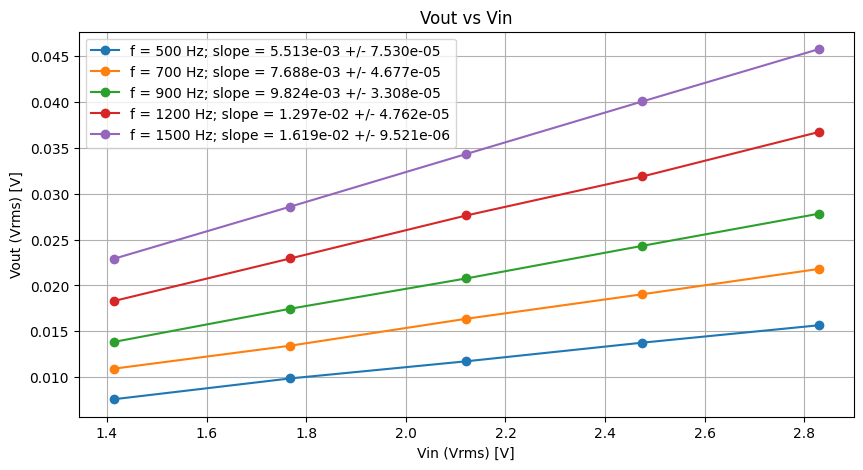

In [2]:
# Vrms from Vp 
Vin_rms = Vin_allfreq / (np.sqrt(2)) 
Vout_obs_avg = np.mean(Vout_obs_allfreq, axis=2) / (np.sqrt(2)) # average of Vout_obs across all trials
Vout_obs_std = np.std(Vout_obs_allfreq, axis=2) / (np.sqrt(2)) # std of Vout_obs across all trials

plt.figure(figsize=(10,5))

slopes_all_freq = []
error_slopes_all_freq = []
points_to_avoid = []

for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]

    slope = Vout_obs_avg[i][indices_to_include] / Vin_rms[i][indices_to_include]
    avg_slope = np.mean(slope)
    std_slope = np.std(slope)
    slopes_all_freq.append(avg_slope)
    error_slopes_all_freq.append(std_slope)

for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]        
    plt.plot(Vin_rms[i][indices_to_include],Vout_obs_avg[i][indices_to_include],'o-',label=f'f = {frequencies[i]} Hz; slope = {slopes_all_freq[i]:.3e} +/- {error_slopes_all_freq[i]:.3e}')
    


plt.xlabel('Vin (Vrms) [V]')
plt.ylabel('Vout (Vrms) [V]')
plt.title('Vout vs Vin')
plt.legend()
plt.grid()
plt.savefig(f'Vout_vs_Vin{trial_name_}.png')
plt.show()

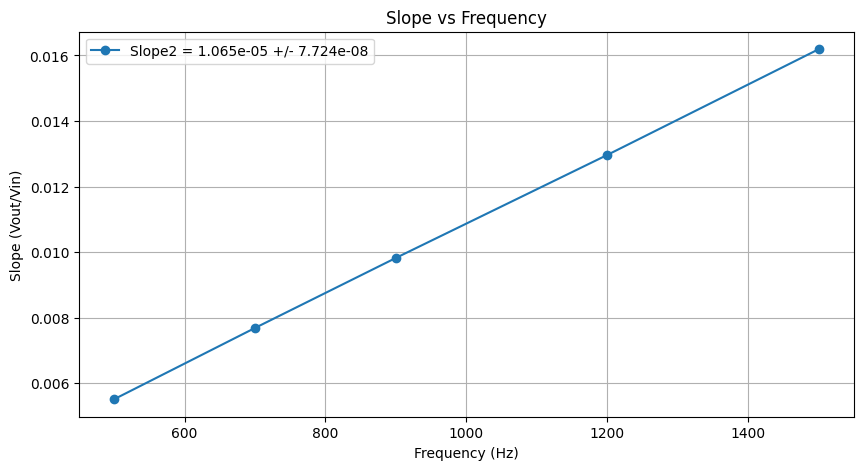

In [3]:
# slope2 from frequency vs slope

slopes_all_freq = np.array(slopes_all_freq)
error_slopes_all_freq = np.array(error_slopes_all_freq)
frequencies = np.array(frequencies)

slope2, _ = np.polyfit(frequencies,slopes_all_freq,1)

# calculate the standard deviation of the slope2
slope2_std = np.sqrt(np.sum(error_slopes_all_freq**2) / (len(frequencies) - 2)) / np.sqrt(np.sum((frequencies - np.mean(frequencies))**2))

plt.figure(figsize=(10,5))
plt.errorbar(frequencies,slopes_all_freq, fmt='o-', label=f'Slope2 = {slope2:.3e} +/- {slope2_std:.3e}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Slope (Vout/Vin)')
plt.title('Slope vs Frequency')
plt.legend()
plt.grid()
plt.savefig(f'Slope_vs_Frequency{trial_name_}.png')
plt.show()

In [11]:
R = 1e3
R_f = 10e3

R = 0.998e3
R_f = 53.8e3

R_coil = 4.7e3

G = 1 + (R_f / R) # Gain

M = (R_coil * slope2) / (2 * np.pi * G)
M_error = M * (slope2_std / slope2)
relative_error = (M_error / M) * 100

print(f"Mutual Inductance = {M:.3e} +/- {M_error:.3e} H")
print(f"Relative error = {relative_error:.3f} % (with respect to the observed)")

# calculating the avg phase and std phase across all frequencies and trials
avg_phase = np.mean(Phase_obs_allfreq) # degrees
std_phase = np.std(Phase_obs_allfreq) # degrees

print(f"Phase = {avg_phase:.3f} +/- {std_phase:.3f} degrees")

Mutual Inductance = 1.451e-04 +/- 1.052e-06 H
Relative error = 0.725 % (with respect to the observed)
Phase = -96.864 +/- 4.311 degrees


### Low resistance measurements



In [32]:
frequencies = [] # Hz 
Vin_allfreq = [] # Vp (V)

# Vout observed through Lockin detector (V)
Vout_obs_allfreq = []
# Phase observed through Lockin detector (degrees)
Phase_obs_allfreq = []
trial_name = 'trial5_r'

In [50]:
curr_freq = 700

if len(frequencies) == 0 or frequencies[-1] != curr_freq:
    frequencies.append(curr_freq)

    Vin = [] # Vpp (V)

    # Vout observed through Lockin detector (V)
    Vout_obs = []p
    # Phase observed through Lockin detector (degrees)
    Phase_obs = []

    f = curr_freq

    t_gap = (1/(f*N_div))*10**6 #us
    warmup_flag = 0
    print(f"Running for f = {f} Hz")
    print(f"t_gap = {t_gap} us")

Curr_Vin = 3.5

Vin.append(Curr_Vin)
for i in range(20):
    A , phase, warmup_flag = Lockin_detector_single_run(warmup_flag, f, t_gap)
    if i == 0:
        Vout_obs.append([A])
        Phase_obs.append([phase])
    else:
        Vout_obs[-1].append(A)
        Phase_obs[-1].append(phase)

if Curr_Vin == 3.5:
    Vin = np.array(Vin)
    Vout_obs = np.array(Vout_obs)
    Phase_obs = np.array(Phase_obs)

    Vin_allfreq.append(Vin)
    Vout_obs_allfreq.append(Vout_obs)
    Phase_obs_allfreq.append(Phase_obs)

Observed Amplitude: 0.0738813299504384
Observed Phase: 0.363552912872046 deg
Observed Amplitude: 0.07394961332297238
Observed Phase: 0.33590931336695523 deg
Observed Amplitude: 0.07396243545003901
Observed Phase: 0.4272536235753659 deg
Observed Amplitude: 0.07384588130626432
Observed Phase: 0.5307095939578664 deg
Observed Amplitude: 0.07391311657542277
Observed Phase: 0.5205373329297358 deg
Observed Amplitude: 0.07381893390498598
Observed Phase: 0.4432932766811377 deg
Observed Amplitude: 0.07386464049753949
Observed Phase: 0.40297547316596355 deg
Observed Amplitude: 0.07392915505312754
Observed Phase: 0.3647252881156868 deg
Observed Amplitude: 0.07388269958757952
Observed Phase: 0.5847216891396319 deg
Observed Amplitude: 0.07392136717302229
Observed Phase: 0.5407180089112233 deg
Observed Amplitude: 0.07396667446666476
Observed Phase: 0.5088520798954186 deg
Observed Amplitude: 0.0738837026947886
Observed Phase: 0.5563420131580505 deg
Observed Amplitude: 0.07388649664840066
Observed Phas

In [51]:
np.save(f'Vin_allfreq{trial_name}.npy',Vin_allfreq)
np.save(f'Vout_obs_allfreq{trial_name}.npy',Vout_obs_allfreq)
np.save(f'Phase_obs_allfreq{trial_name}.npy',Phase_obs_allfreq)
np.save(f'frequencies{trial_name}.npy',frequencies)

In [83]:
# load data and process
import numpy as np
trial_name_ = 'trial5_r'

Vin_allfreq = np.load(f'Vin_allfreq{trial_name_}.npy')
Vout_obs_allfreq = np.load(f'Vout_obs_allfreq{trial_name_}.npy')
Phase_obs_allfreq = np.load(f'Phase_obs_allfreq{trial_name_}.npy')
frequencies = np.load(f'frequencies{trial_name_}.npy')

[300 500 700]


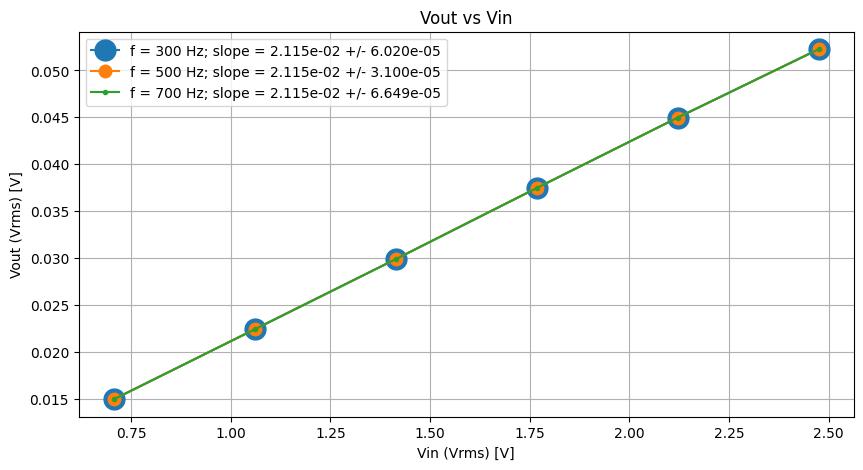

In [84]:
# Vrms from Vpp 
import matplotlib.pyplot as plt

print(frequencies)
Vin_rms = Vin_allfreq / (np.sqrt(2)) # Vp to Vrms
Vout_obs_avg = np.mean(Vout_obs_allfreq/ (np.sqrt(2)), axis=2) #average over trials
Vout_obs_std = np.std(Vout_obs_allfreq/ (np.sqrt(2)), axis=2) #std over trials

plt.figure(figsize=(10,5))


slopes_all_freq = []
error_slopes_all_freq = []
points_to_avoid = []

for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]

    slope, intercept = np.polyfit(Vin_rms[i][indices_to_include],Vout_obs_avg[i][indices_to_include],1)
    error_slopes_all_freq.append(np.std(Vout_obs_avg[i][indices_to_include] - (slope * Vin_rms[i][indices_to_include] + intercept)))
    
    slope = Vout_obs_avg[i][indices_to_include] / Vin_rms[i][indices_to_include]
    avg_slope = np.mean(slope)
    std_slope = np.std(slope)
    slopes_all_freq.append(avg_slope)
    error_slopes_all_freq.append(std_slope)

marker_sizes = [15,9,3]
for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]        
    plt.plot(Vin_rms[i][indices_to_include],Vout_obs_avg[i][indices_to_include],'o-',label=f'f = {frequencies[i]} Hz; slope = {slopes_all_freq[i]:.3e} +/- {error_slopes_all_freq[i]:.3e}',markersize=marker_sizes[i])



plt.xlabel('Vin (Vrms) [V]')
plt.ylabel('Vout (Vrms) [V]')
plt.title('Vout vs Vin (calibration)')
plt.legend()
plt.grid()
plt.savefig(f'Vout_vs_Vin{trial_name_}.png')
plt.show()

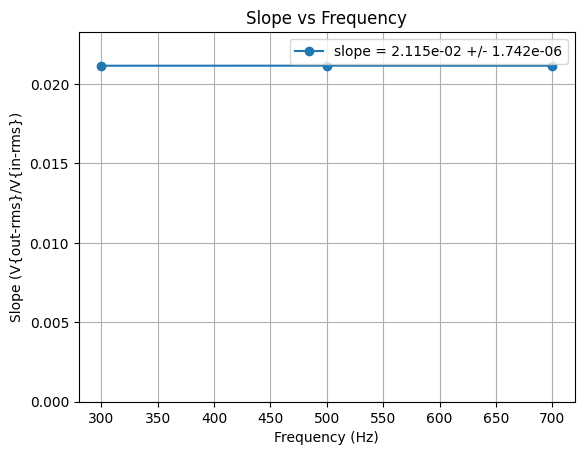

In [85]:
avg_slope = np.mean(slopes_all_freq)
std_slope = np.std(slopes_all_freq)

plt.plot(frequencies,slopes_all_freq,'o-',label= f'slope = {avg_slope:.3e} +/- {std_slope:.3e}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Slope (V{out-rms}/V{in-rms})')
plt.title('Slope vs Frequency')
plt.ylim(0,slopes_all_freq[0]*1.1)
plt.grid()
plt.legend()
plt.savefig(f'Slope_vs_Frequency{trial_name_}.png')
plt.show()

In [86]:
r_theoretical = 100 # ohm
R = 4.7e3 
alpha = 1

index = 1 # doesnt make much difference since the slope is constant
slope = slopes_all_freq[index]
slope_std = error_slopes_all_freq[index]

r_observed = R * avg_slope / alpha
R_obs_error = r_observed * (slope_std / slope)
relative_error_R = (abs(r_observed - r_theoretical) / r_theoretical) * 100 # in percentage

print(f"R_observed = {r_observed:.3f}(+/-){R_obs_error:.3f} ohm")
print(f"R_theoretical = {r_theoretical} ohm")
print(f"Relative error = {relative_error_R:.3f}%")

R_observed = 99.401(+/-)0.146 ohm
R_theoretical = 100 ohm
Relative error = 0.599%


### Calibration


In [97]:
# load data and process
import numpy as np
trial_name_ = 'trial1_calibration'

Vin_allfreq = np.load(f'Vin_allfreq{trial_name_}.npy')
Vout_obs_allfreq = np.load(f'Vout_obs_allfreq{trial_name_}.npy')
# Phase_obs_allfreq = np.load(f'Phase_obs_allfreq{trial_name_}.npy')
# frequencies = np.load(f'frequencies{trial_name_}.npy')
frequencies = np.array([i for i in range(300, 801,100)])

[300 400 500 600 700 800]


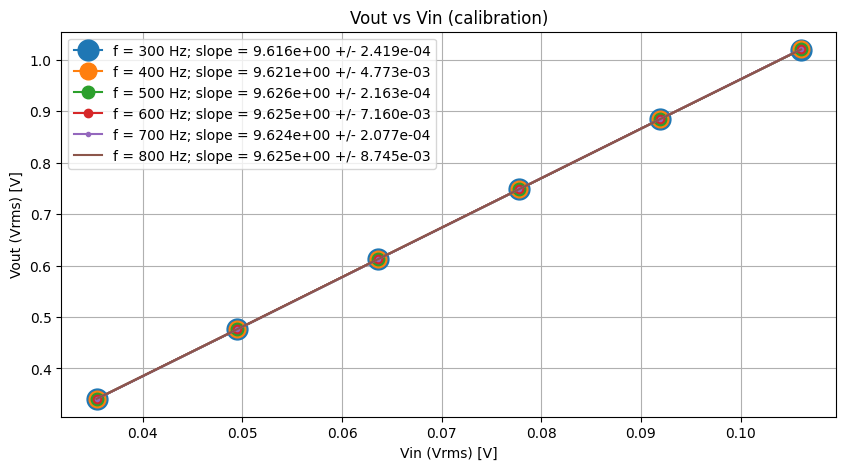

In [98]:
# Vrms from Vpp 
import matplotlib.pyplot as plt

print(frequencies)
Vin_rms = Vin_allfreq / (np.sqrt(2)) # Vp to Vrms
Vout_obs_avg = np.mean(Vout_obs_allfreq/ (np.sqrt(2)), axis=2) #average over trials
Vout_obs_std = np.std(Vout_obs_allfreq/ (np.sqrt(2)), axis=2) #std over trials

plt.figure(figsize=(10,5))


slopes_all_freq = []
error_slopes_all_freq = []
points_to_avoid = []

for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]

    slope, intercept = np.polyfit(Vin_rms[i][indices_to_include],Vout_obs_avg[i][indices_to_include],1)
    error_slopes_all_freq.append(np.std(Vout_obs_avg[i][indices_to_include] - (slope * Vin_rms[i][indices_to_include] + intercept)))
    
    slope = Vout_obs_avg[i][indices_to_include] / Vin_rms[i][indices_to_include]
    avg_slope = np.mean(slope)
    std_slope = np.std(slope)
    slopes_all_freq.append(avg_slope)
    error_slopes_all_freq.append(std_slope)

marker_sizes = [i for i in range(15,-1,-3)]
for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]        
    plt.plot(Vin_rms[i][indices_to_include],Vout_obs_avg[i][indices_to_include],'o-',label=f'f = {frequencies[i]} Hz; slope = {slopes_all_freq[i]:.3e} +/- {error_slopes_all_freq[i]:.3e}',markersize=marker_sizes[i])



plt.xlabel('Vin (Vrms) [V]')
plt.ylabel('Vout (Vrms) [V]')
plt.title('Vout vs Vin (calibration)')
plt.legend()
plt.grid()
plt.savefig(f'Vout_vs_Vin{trial_name_}.png')
plt.show()

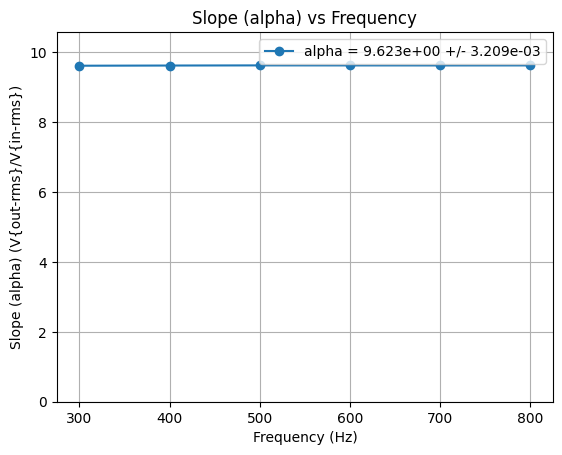

In [99]:
avg_slope = np.mean(slopes_all_freq)
std_slope = np.std(slopes_all_freq)

plt.plot(frequencies,slopes_all_freq,'o-',label= f'alpha = {avg_slope:.3e} +/- {std_slope:.3e}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Slope (alpha) (V{out-rms}/V{in-rms})')
plt.title('Slope (alpha) vs Frequency')
plt.ylim(0,slopes_all_freq[0]*1.1)
plt.grid()
plt.legend()
plt.savefig(f'Slope_vs_Frequency{trial_name_}.png')
plt.show()

In [100]:
avg_alpha = np.mean(slopes_all_freq)
std_alpha = np.std(slopes_all_freq)

slopes_all_freq1 = np.array(slopes_all_freq)

### Res endesem


In [101]:
# load data and process
import numpy as np
trial_name_ = 'trial2_endsem'

Vin_allfreq = np.load(f'Vin_allfreq{trial_name_}.npy')
Vout_obs_allfreq = np.load(f'Vout_obs_allfreq{trial_name_}.npy')
# Phase_obs_allfreq = np.load(f'Phase_obs_allfreq{trial_name_}.npy')
# frequencies = np.load(f'frequencies{trial_name_}.npy')
frequencies = np.array([i for i in range(300, 801,100)])

[300 400 500 600 700 800]


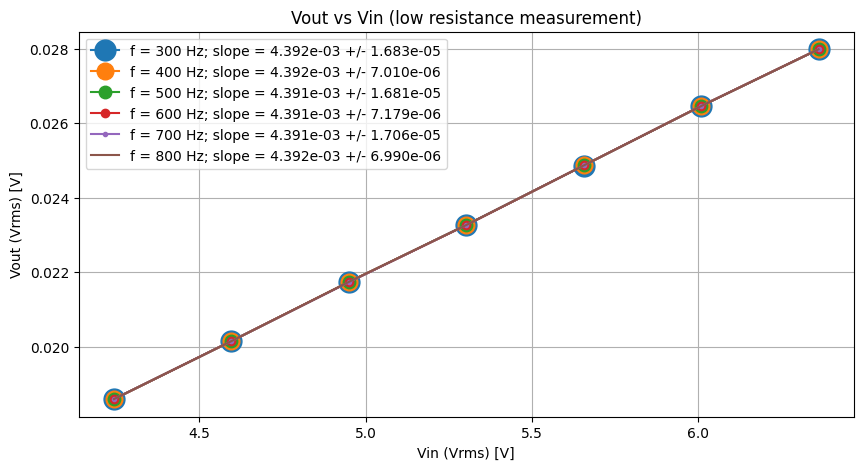

In [102]:
# Vrms from Vpp 
import matplotlib.pyplot as plt

print(frequencies)
Vin_rms = Vin_allfreq / (np.sqrt(2)) # Vp to Vrms
Vout_obs_avg = np.mean(Vout_obs_allfreq/ (np.sqrt(2)), axis=2) #average over trials
Vout_obs_std = np.std(Vout_obs_allfreq/ (np.sqrt(2)), axis=2) #std over trials

plt.figure(figsize=(10,5))


slopes_all_freq = []
error_slopes_all_freq = []
points_to_avoid = []

for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]

    slope, intercept = np.polyfit(Vin_rms[i][indices_to_include],Vout_obs_avg[i][indices_to_include],1)
    error_slopes_all_freq.append(np.std(Vout_obs_avg[i][indices_to_include] - (slope * Vin_rms[i][indices_to_include] + intercept)))
    
    slope = Vout_obs_avg[i][indices_to_include] / Vin_rms[i][indices_to_include]
    avg_slope = np.mean(slope)
    std_slope = np.std(slope)
    slopes_all_freq.append(avg_slope)
    error_slopes_all_freq.append(std_slope)

marker_sizes = [i for i in range(15,-1,-3)]
for i in range(len(frequencies)):
    indices_to_avoid = []
    for point in points_to_avoid:
        if i == point[0]:
            indices_to_avoid.append(point[1])
    indices_to_include = [i for i in range(len(Vout_obs_avg[i])) if i not in indices_to_avoid]        
    plt.plot(Vin_rms[i][indices_to_include],Vout_obs_avg[i][indices_to_include],'o-',label=f'f = {frequencies[i]} Hz; slope = {slopes_all_freq[i]:.3e} +/- {error_slopes_all_freq[i]:.3e}',markersize=marker_sizes[i])



plt.xlabel('Vin (Vrms) [V]')
plt.ylabel('Vout (Vrms) [V]')
plt.title('Vout vs Vin (low resistance measurement)')
plt.legend()
plt.grid()
plt.legend()
plt.savefig(f'Vout_vs_Vin{trial_name_}.png')
plt.show()

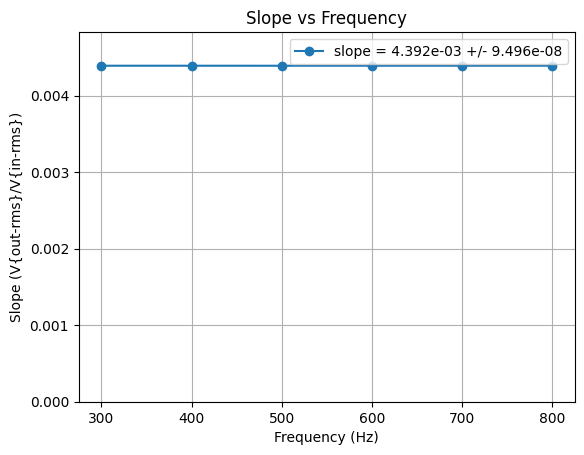

In [103]:
avg_slope = np.mean(slopes_all_freq)
std_slope = np.std(slopes_all_freq)

slopes_all_freq2 = np.array(slopes_all_freq)

plt.plot(frequencies,slopes_all_freq,'o-',label= f'slope = {avg_slope:.3e} +/- {std_slope:.3e}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Slope (V{out-rms}/V{in-rms})')
plt.title('Slope vs Frequency')
plt.ylim(0,slopes_all_freq[0]*1.1)
plt.grid()
plt.legend()
plt.savefig(f'Slope_vs_Frequency{trial_name_}.png')
plt.show()

In [105]:
R = 1e3 
alpha = 9.623

# after running codes for calibration 
# (.. measuring calibration..)
avg_alpha = np.mean(slopes_all_freq1)
std_alpha = np.std(slopes_all_freq1)

# after running codes for low resistance measurement
# (.. measuring low resistance..)
avg_slope = np.mean(slopes_all_freq2)
slope_std = np.std(slopes_all_freq2)

print(f"alpha_observed = {avg_alpha:.3e} +/- {std_alpha:.3e}")

print(f'slope = {avg_slope:.3e} +/- {slope_std:.3e}')

r_observed = R * avg_slope / avg_alpha
R_obs_error = r_observed * np.sqrt((slope_std / avg_slope)**2 + (std_alpha / avg_alpha)**2)

print(f"R_observed = {r_observed}(+/-){R_obs_error} ohm")


alpha_observed = 9.623e+00 +/- 3.209e-03
slope = 4.392e-03 +/- 9.496e-08
R_observed = 0.45637373119921365(+/-)0.00015252887239990622 ohm


### printing data

In [73]:
# load data and process
import numpy as np
trial_name_ = 'trial1_calibration'

Vin_allfreq = np.load(f'Vin_allfreq{trial_name_}.npy')
Vout_obs_allfreq = np.load(f'Vout_obs_allfreq{trial_name_}.npy')
# Phase_obs_allfreq = np.load(f'Phase_obs_allfreq{trial_name_}.npy')
# frequencies = np.load(f'frequencies{trial_name_}.npy')
frequencies = np.array([i for i in range(300, 801,100)])

print(Vin_allfreq.shape)
print(Vout_obs_allfreq.shape)
print(frequencies.shape)

(6, 6)
(6, 6, 20)
(6,)


In [74]:
# avergae over trials
# Vin_allfreq = np.mean(Vin_allfreq, axis=2)
Vout_obs_allfreq = np.mean(Vout_obs_allfreq, axis=2)

# Vrms from Vp
Vin_rms = Vin_allfreq / (np.sqrt(2))
Vout_obs_avg = Vout_obs_allfreq / (np.sqrt(2))

# print data as table
import pandas as pd

for i in range(len(frequencies)):
    print(f'f = {frequencies[i]} Hz')
    data = {'Vin (Vrms)':Vin_rms[i],'Vout (Vrms)':Vout_obs_avg[i]}
    df = pd.DataFrame(data)
    print(df)

f = 300 Hz
   Vin (Vrms)  Vout (Vrms)
0    0.035355     0.340270
1    0.049497     0.475717
2    0.063640     0.612145
3    0.077782     0.747825
4    0.091924     0.884073
5    0.106066     1.019359
f = 400 Hz
   Vin (Vrms)  Vout (Vrms)
0    0.035355     0.340703
1    0.049497     0.476011
2    0.063640     0.612369
3    0.077782     0.748145
4    0.091924     0.884304
5    0.106066     1.019781
f = 500 Hz
   Vin (Vrms)  Vout (Vrms)
0    0.035355     0.340972
1    0.049497     0.476260
2    0.063640     0.612617
3    0.077782     0.748411
4    0.091924     0.884489
5    0.106066     1.020033
f = 600 Hz
   Vin (Vrms)  Vout (Vrms)
0    0.035355     0.340717
1    0.049497     0.476313
2    0.063640     0.612643
3    0.077782     0.748459
4    0.091924     0.884429
5    0.106066     1.020070
f = 700 Hz
   Vin (Vrms)  Vout (Vrms)
0    0.035355     0.340789
1    0.049497     0.476272
2    0.063640     0.612266
3    0.077782     0.748378
4    0.091924     0.884461
5    0.106066     1.020129


In [76]:
# load data and process
import numpy as np
trial_name_ = 'trial2_endsem'

Vin_allfreq = np.load(f'Vin_allfreq{trial_name_}.npy')
Vout_obs_allfreq = np.load(f'Vout_obs_allfreq{trial_name_}.npy')
# Phase_obs_allfreq = np.load(f'Phase_obs_allfreq{trial_name_}.npy')
# frequencies = np.load(f'frequencies{trial_name_}.npy')
frequencies = np.array([i for i in range(300, 801,100)])

print(Vin_allfreq.shape)
print(Vout_obs_allfreq.shape)
print(frequencies.shape)
# avergae over trials
# Vin_allfreq = np.mean(Vin_allfreq, axis=2)
Vout_obs_allfreq = np.mean(Vout_obs_allfreq, axis=2)

# Vrms from Vp
Vin_rms = Vin_allfreq / (np.sqrt(2))
Vout_obs_avg = Vout_obs_allfreq / (np.sqrt(2))

# print data as table
import pandas as pd

for i in range(len(frequencies)):
    print(f'f = {frequencies[i]} Hz')
    data = {'Vin (Vrms)':Vin_rms[i],'Vout (Vrms)':Vout_obs_avg[i]}
    df = pd.DataFrame(data)
    print(df)

(6, 7)
(6, 7, 20)
(6,)
f = 300 Hz
   Vin (Vrms)  Vout (Vrms)
0    4.242641     0.018590
1    4.596194     0.020154
2    4.949747     0.021736
3    5.303301     0.023270
4    5.656854     0.024863
5    6.010408     0.026465
6    6.363961     0.027987
f = 400 Hz
   Vin (Vrms)  Vout (Vrms)
0    4.242641     0.018589
1    4.596194     0.020150
2    4.949747     0.021738
3    5.303301     0.023268
4    5.656854     0.024866
5    6.010408     0.026463
6    6.363961     0.027988
f = 500 Hz
   Vin (Vrms)  Vout (Vrms)
0    4.242641     0.018593
1    4.596194     0.020148
2    4.949747     0.021735
3    5.303301     0.023267
4    5.656854     0.024866
5    6.010408     0.026461
6    6.363961     0.027985
f = 600 Hz
   Vin (Vrms)  Vout (Vrms)
0    4.242641     0.018593
1    4.596194     0.020150
2    4.949747     0.021734
3    5.303301     0.023263
4    5.656854     0.024866
5    6.010408     0.026464
6    6.363961     0.027987
f = 700 Hz
   Vin (Vrms)  Vout (Vrms)
0    4.242641     0.018593
1   